In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import re
import seaborn as sns

## Load Files

In [2]:
# Read all columns and concatenate them into a single dataframe
df = pd.read_csv("join_df.csv", header = 0, sep="\t", index_col=0)

In [3]:
df.columns

Index(['ISSN', 'JIF', 'Eigenfactor', 'Year Published', 'Authors',
       'Document Title', 'Publication Name', 'Author Keywords', 'Abstract',
       'Author Address', 'Reprint Address', 'Funding Agency and Grant Number',
       'Cited Reference Count', 'Times cited', 'Usage Count (Last 180 Days)',
       'Usage Count (Since 2013)', 'Publisher Address', 'Page Count',
       'Web of Science Categories', 'eISSN'],
      dtype='object')

In [4]:
df.describe()

,JIF,Eigenfactor,Year Published,Cited Reference Count,Times cited,Usage Count (Last 180 Days),Usage Count (Since 2013),Page Count
count,4542.000000,1713.000000,4542.000000,4542.000000,4542.000000,4542.000000,4542.000000,4542.000000
mean,4.139038,0.061761,2010.597754,39.287098,34.501321,0.413915,9.320123,9.428225
std,2.660118,0.120662,6.725303,17.822460,51.834073,1.158430,13.245821,3.576025
min,0.193000,0.001000,2000.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,2.524000,0.014000,2005.000000,27.000000,9.000000,0.000000,3.000000,7.000000
50%,3.645500,0.034000,2010.000000,37.000000,19.000000,0.000000,6.000000,9.000000
75%,5.115000,0.061000,2016.000000,48.000000,39.000000,0.000000,12.000000,11.000000
max,87.244000,1.540000,2022.000000,273.000000,833.000000,26.000000,271.000000,38.000000


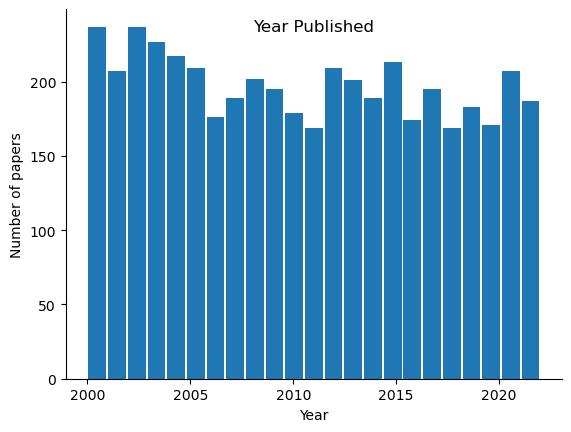

In [5]:
fig, ax = plt.subplots()
ax.hist(df['Year Published'], bins=23, rwidth=0.9)
ax.set_title('Year Published', y=1.0, pad=-16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Number of papers')
ax.set_xlabel('Year')
plt.show()

fig_path = os.path.join('.', 'report_latex', 'Images', 'year_hist.png')
fig.savefig(fig_path, dpi=100)

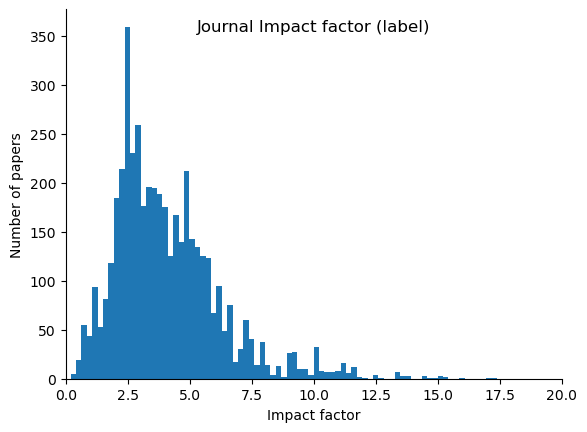

In [6]:
features = ['Year Published', 'JIF', 'Page Count', 'Times cited']
fig, ax = plt.subplots()

ax.hist(df[features[1]], bins=400)
ax.set_title('Journal Impact factor (label)', y=1.0, pad=-16)
ax.set_xlim(0,20)
ax.set_ylabel('Number of papers')
ax.set_xlabel('Impact factor')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

fig_path = os.path.join('.', 'report_latex', 'Images', 'JIF_hist.png')
fig.savefig(fig_path, dpi=100)

In [7]:
categories = df['Web of Science Categories'].apply(lambda x: x.split(';')).explode()
categories = categories.apply(lambda x: x.strip())
categories = categories.apply(lambda x: 'Chemistry' if 'Chemistry' in x else x)
categories = categories.apply(lambda x: 'Biochemistry' if 'Biochemi' in x else x)
categories = categories.apply(lambda x: 'Neurosciences' if 'Neuro' in x else x)
categories.groupby(categories).size().sort_values(ascending=False).head(10)

Web of Science Categories
Chemistry                                        1685
Pharmacology & Pharmacy                          1232
Neurosciences                                    1177
Biochemistry                                     1061
Radiology, Nuclear Medicine & Medical Imaging     990
Psychiatry                                        195
Endocrinology & Metabolism                        167
Multidisciplinary Sciences                        137
Oncology                                          108
Medicine, Research & Experimental                  88
Name: Web of Science Categories, dtype: int64

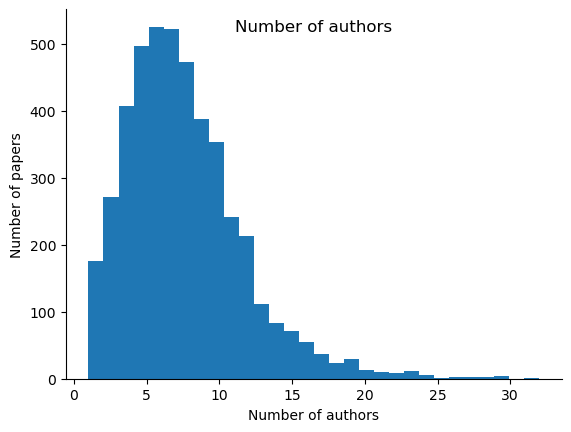

In [8]:
df['num_auth'] = df['Authors'].apply(lambda x: len(x.split(';')))
fig, ax = plt.subplots()
ax.hist(df['num_auth'], bins=30)
ax.set_title('Number of authors', y=1.0, pad=-16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Number of papers')
ax.set_xlabel('Number of authors')
plt.show()

fig_path = os.path.join('.', 'report_latex', 'Images', 'Num_auth.png')
fig.savefig(fig_path, dpi=100)

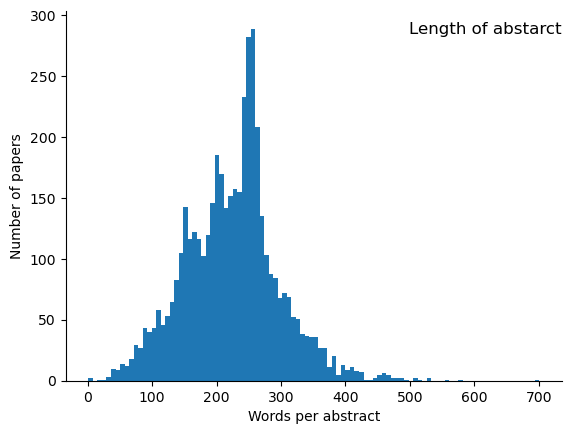

In [9]:
df['num_words'] = df['Abstract'].apply(lambda x: len(str(x).split(' ')))
fig, ax = plt.subplots()
ax.hist(df['num_words'], bins=100)
ax.set_title('Length of abstarct', y=1.0, loc='right', pad=-16)
ax.set_ylabel('Number of papers')
ax.set_xlabel('Words per abstract')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

fig_path = os.path.join('.', 'report_latex', 'Images', 'Abs_len.png')
fig.savefig(fig_path, dpi=100)

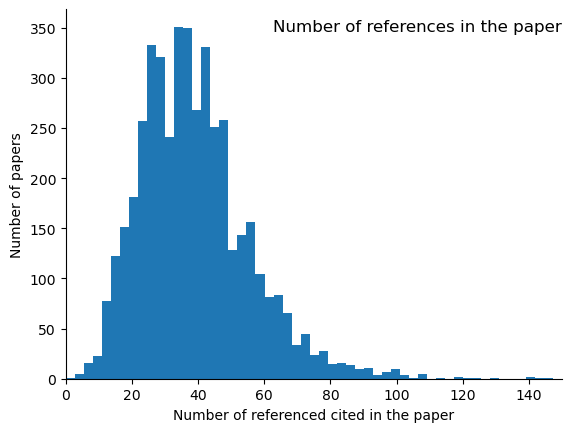

In [10]:
fig, ax = plt.subplots()
ax.hist(df['Cited Reference Count'], bins=100)
ax.set_title('Number of references in the paper', loc='right', y=1.0, pad=-16)
ax.set_xlim(0,150)
ax.set_ylabel('Number of papers')
ax.set_xlabel('Number of referenced cited in the paper')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

fig_path = os.path.join('.', 'report_latex', 'Images', 'Num_ref.png')
fig.savefig(fig_path, dpi=100)

In [11]:
def remove_authors(input_string):
    pattern = re.compile(r'\[.*?\]')
    result_string = re.sub(pattern, '  ', input_string)
    country_set = {address.split(',')[-1].strip() for address in result_string.split(';')}
    country_set_clean = set()
    for contry in country_set:
       if 'usa' in contry.lower(): country_set_clean.add('USA')
       elif 'states' in contry.lower(): country_set_clean.add('USA')
       elif 'england' in contry.lower(): country_set_clean.add('UK')
       elif 'scotland' in contry.lower(): country_set_clean.add('UK')
       elif 'china' in contry.lower(): country_set_clean.add('China')
       elif 'zech' in contry.lower(): country_set_clean.add('Czech Rep.')
       else: country_set_clean.add(contry.rstrip('.'))

    return list(country_set_clean)[0]

In [12]:
df['Auth_country'] = df['Reprint Address'].apply(lambda x: remove_authors(str(x)))

C:\Users\Artem\AppData\Local\Temp\ipykernel_6012\1651076940.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axin.set_xticklabels(to_plot_c.index, rotation = 90)
C:\Users\Artem\AppData\Local\Temp\ipykernel_6012\1651076940.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(to_plot.index, rotation = 90)


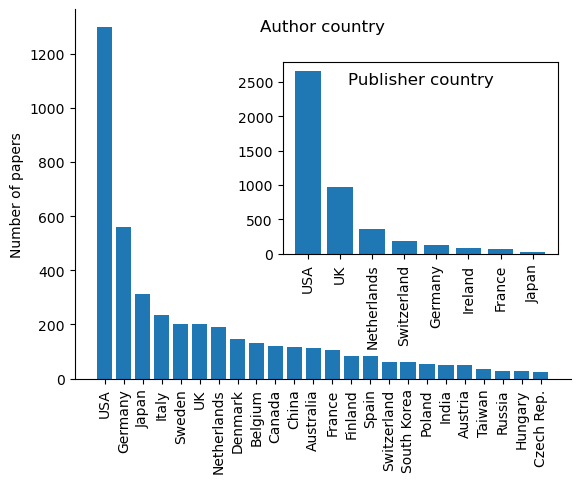

In [25]:

Auth_country_ser = df['Author Address'].astype(str).apply(lambda x: remove_authors(x)).explode()
to_plot = Auth_country_ser.groupby(Auth_country_ser).size().sort_values(ascending=False)
to_plot = to_plot[to_plot.values > 20]
fig, ax = plt.subplots()
ax.bar(x = to_plot.index, height = to_plot.values)
ax.set_title('Country of origin')


df['Pub_country'] = df['Publisher Address'].apply(lambda x: x.split(',')[-1].split(' ')[-1].title())
df['Pub_country'] = df['Pub_country'].apply(lambda x: 'USA' if 'usa' in x.lower() else x)
df['Pub_country'] = df['Pub_country'].apply(lambda x: 'USA' if 'states' in x.lower() else x)
df['Pub_country'] = df['Pub_country'].apply(lambda x: 'UK' if 'ngland' in x.lower() else x)
df['Pub_country'] = df['Pub_country'].apply(lambda x: 'UK' if 'scotland' in x.lower() else x)
df['Pub_country'] = df['Pub_country'].apply(lambda x: 'New Zealand' if 'zealand' in x.lower() else x)
to_plot_c = df['Pub_country'].groupby(df['Pub_country']).size().sort_values(ascending=False)
to_plot_c = to_plot_c[to_plot_c.values > 20]
axin = fig.add_axes([0.45, 0.37, 0.43, 0.4])
axin.bar(x = to_plot_c.index, height = to_plot_c.values)
axin.set_xticklabels(to_plot_c.index, rotation = 90)
axin.set_title('Publisher country', y=1.0, pad=-16)
ax.set_title('Author country', y=1.0, pad=-16)
ax.set_xticklabels(to_plot.index, rotation = 90)
ax.set_ylabel('Number of papers')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()
fig_path = os.path.join('.', 'report_latex', 'Images', 'Countries.png')
fig.savefig(fig_path, dpi=100)

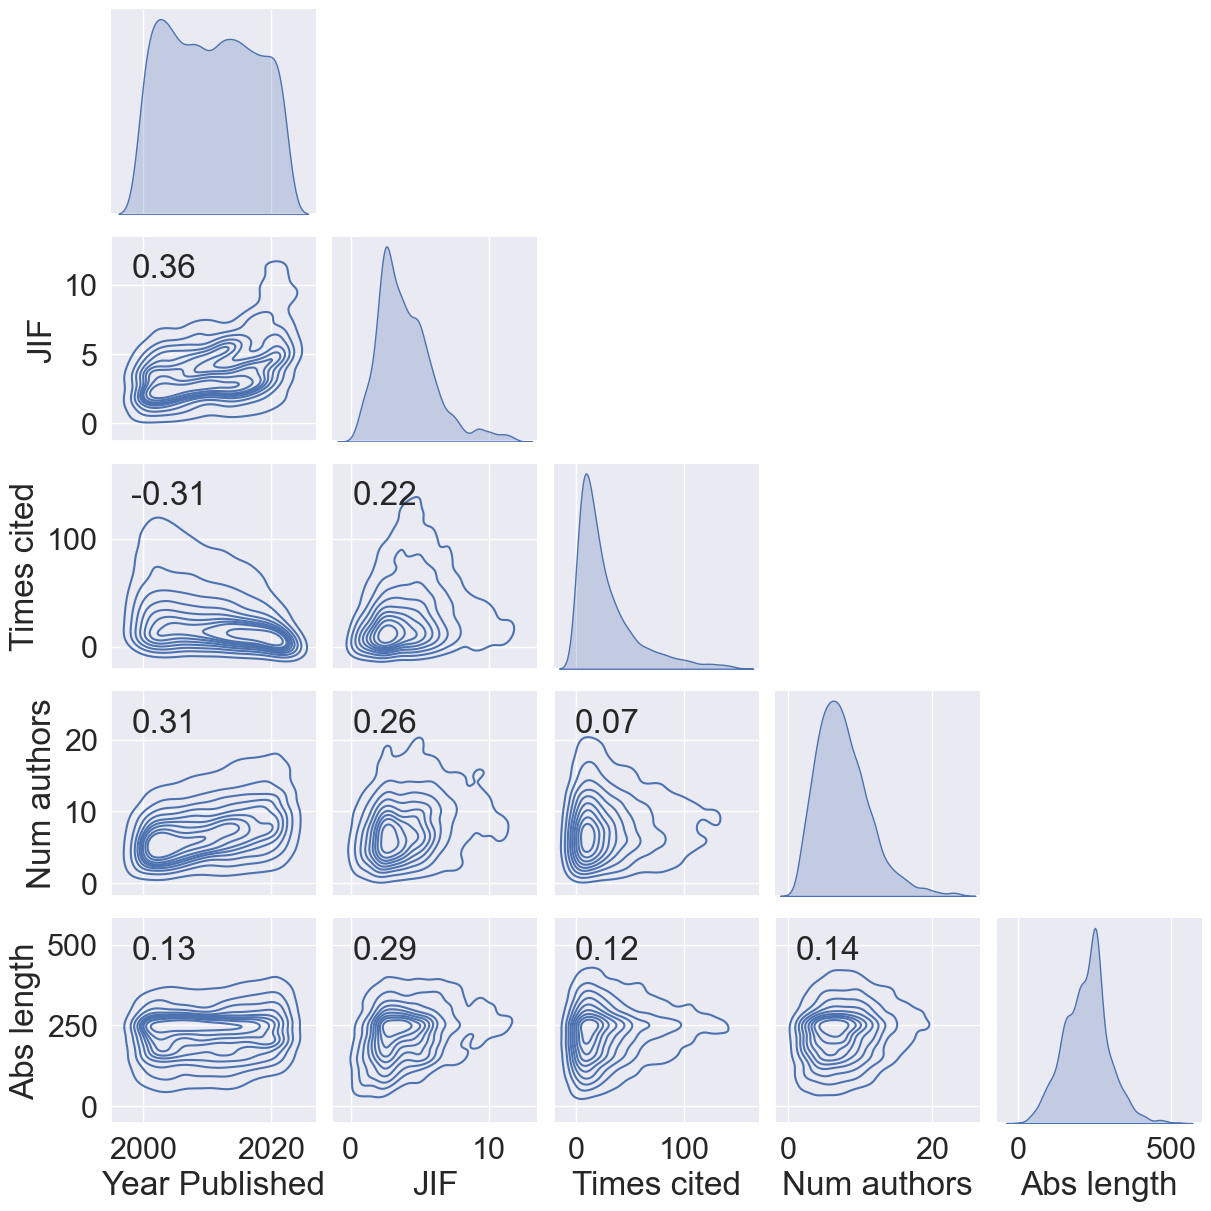

In [26]:
#Prep data
df_clean = df[['Year Published', 'JIF', 'Cited Reference Count', 'Times cited', 'Page Count', 'num_auth', 'num_words', 'Pub_country']]
df_clean.columns = ['Year Published', 'JIF', 'Num references', 'Times cited', 'Page Count', 'Num authors', 'Abs length', 'Pub_country']
df_clean = df_clean[df_clean['Num references']<110]
df_clean = df_clean[df_clean['JIF']<12]
df_clean = df_clean[df_clean['Abs length']<550]
df_clean = df_clean[df_clean['Num authors']<25]
df_clean = df_clean[df_clean['Times cited']<150]

from scipy.stats import pearsonr

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'{r:.2f}', xy=(.1, .8), xycoords=ax.transAxes)


#Draw the plot
sns.set(font_scale=2)
pairplot = sns.pairplot(df_clean[['Year Published', 'JIF', 'Times cited', 'Num authors', 'Abs length']], corner=True, kind="kde")
pairplot.map_lower(corrfunc)

#Save the picture
fig = pairplot.figure
fig_path = os.path.join('.', 'report_latex', 'Images', 'Pairplot.png')
fig.savefig(fig_path, dpi=100)
pairplot

In [16]:
# Convert funding to categorical
df['Funding'] = df['Funding Agency and Grant Number'].notna()

In [17]:
# get rid of the Elsivier copyright
df['Abstract'] = df['Abstract'].apply(lambda x: x.split('(C)')[0])

In [18]:
df_features = df[['JIF', 'Year Published', 'Abstract', 'Funding',
       'Cited Reference Count', 'Times cited', 'Usage Count (Since 2013)', 'Page Count', 'num_auth', 'num_words',
       'Auth_country', 'Pub_country']]

df_features.to_csv('features.csv', '\t')

C:\Users\Artem\AppData\Local\Temp\ipykernel_6012\3470930813.py:5: FutureWarning: Starting with pandas version 3.0 all arguments of to_csv except for the argument 'path_or_buf' will be keyword-only.
  df_features.to_csv('features.csv', '\t')
